# Equation Discovery with Symbolic Regression to Paramterize Heat Flux in the Atmospheric Boundary Layer

*Authors: Antony Sikorski*

This notebook should make it easy to perform equation discovery with the use of the function `discover_eqs`. 

This function uses a number of supporting functions from the accompanying `functions.py` file, and should output a dataframe of possible equations.

We use the `PySR` package for symbolic regression, an ML method for finding interpretable symbolic expressions.

In [1]:
#importing libraries
# from pdfs import *
import os
import re

import xarray as xr
import netCDF4 as nc
import h5netcdf

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import pysr
from pysr import PySRRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from functions import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Some quick data processing: 

In [2]:
path = 'C:/Users/anton/Desktop/Career/LEAP_nyc_Summer2024/les_sim_2/'

directories, items = list_directories_files(path)
print("Directories starting with 'Ug':", directories)
print("Files starting with 'Ug':", items)

Directories starting with 'Ug': []
Files starting with 'Ug': ['Ug16Q000_IV.nc', 'Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_I.nc', 'Ug16Q006_IV.nc', 'Ug16Q010_IV.nc', 'Ug1Q01_II.nc', 'Ug2Q010_I.nc', 'Ug2Q010_IV.nc', 'Ug2Q01_III.nc', 'Ug2Q024_I.nc', 'Ug8Q003_II.nc', 'Ug8Q003_III.nc', 'Ug8Q003_IV.nc', 'Ug8Q006_IV.nc']


In [3]:
for item in items:
    ds_stat = nc.Dataset( os.path.join(path, item), mode='r')
    if 'budget' in ds_stat.groups:
        print ("budget is in", item)
    else:
        print ("budget is not in", item)

budget is not in Ug16Q000_IV.nc
budget is in Ug16Q001_IV.nc
budget is in Ug16Q003_IV.nc
budget is in Ug16Q006_I.nc
budget is in Ug16Q006_IV.nc
budget is in Ug16Q010_IV.nc
budget is in Ug1Q01_II.nc
budget is in Ug2Q010_I.nc
budget is in Ug2Q010_IV.nc
budget is in Ug2Q01_III.nc
budget is in Ug2Q024_I.nc
budget is in Ug8Q003_II.nc
budget is in Ug8Q003_III.nc
budget is in Ug8Q003_IV.nc
budget is in Ug8Q006_IV.nc


In [4]:
for item in items[1:]:
    print(item)
    df = nc.Dataset(path + '/' + item, mode='r')
    print(df)

Ug16Q001_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q003_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q006_I.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q006_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(90)
    variables(dimensions): float64 time(time), float64 z(z), f

In [5]:
target_z_dim = 384

selected_files = []

for item in items[1:]:
        df = nc.Dataset(os.path.join(path, item), mode='r')
        if df.dimensions['z'].size == target_z_dim:
            selected_files.append(item)
        df.close()


print("Total number of files: ", len(items))
print("Number of valid files (same z and zh dims): ", len(selected_files))
print("Valid files: ", selected_files)

Total number of files:  15
Number of valid files (same z and zh dims):  11
Valid files:  ['Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_IV.nc', 'Ug16Q010_IV.nc', 'Ug1Q01_II.nc', 'Ug2Q010_IV.nc', 'Ug2Q01_III.nc', 'Ug8Q003_II.nc', 'Ug8Q003_III.nc', 'Ug8Q003_IV.nc', 'Ug8Q006_IV.nc']


train pysr on each simulation separately to see if it can then pick up dependency on `ug` and `q`, try training on two opposite simulations at the same time to see if the variables have a more pronounced effect. if successful, try on all simulations and plot the variability in coefficients for each simulation. 

would be fun to make a plot of the different coefficient values across different Qs and Ugs. 

In [6]:
#eqs_Ug16Q001_IV = discover_eqs(path, ['Ug16Q001_IV.nc'], time_avg = 15, indices = np.s_[:, 0:200], difficulty = "hard")

In [7]:
# display(eqs_Ug16Q001_IV.iloc[8, 4])
# eqs_Ug16Q001_IV

WHAT IF USTAR IS SUPPOSED TO BE IN FRONT OF THE MULTIPLIED THIRD TERM

In [8]:
#eqs_Ug2Q010_IV = discover_eqs(path, ['Ug2Q010_IV.nc'], time_avg = 15, indices = np.s_[:, 0:200], difficulty = "hard")

In [9]:
# display(eqs_Ug2Q010_IV.iloc[9, 4])
# eqs_Ug2Q010_IV

In [10]:
df_coefs = pd.DataFrame(columns = ['File', 'Avg Ustar', 'Avg Tau', 'Ug', 'Q', 'RMSE', 'R2', 'C1', 'C2', 'C3'])

for item in selected_files:
    #file
    print(item)
    ds_stat = nc.Dataset(os.path.join(path, item), mode='r')

    #ustar
    ustar = ds_stat.groups['default'].variables['ustar'][:]
    print("Mean of ustar: ", np.mean(ustar))

    #tau
    grr = 9.8
    T_0 = 300
    beta = grr/T_0
    pbl_height = ds_stat.groups['thermo'].variables['zi'][:]
    wtheta_surface = ds_stat.groups['thermo']['th_flux'][:,0]  
    wstar = np.power( beta * (wtheta_surface) * pbl_height , 1/3) 
    tau = pbl_height/wstar
    print("Mean of tau: ", np.mean(tau))

    #ug and q
    ug, q = extract_ug_q(item)
    print("Ug: ", ug)
    print("Q: ", q)

    #rmse, r2
    fitted_model, X_train, X_test, y_train, y_test, rmse, r2, coefficients = LES_linear_regressor(path, [item], time_avg = 15, indices = np.s_[:, 0:200])
    
    #c1, c2, c3
    c1 = coefficients[0]
    c2 = coefficients[1]
    c3 = coefficients[2]

    # Create a new row to be appended
    new_row = {
        'File': item,
        'Avg Ustar': np.mean(ustar),
        'Avg Tau': np.mean(tau),
        'Ug': ug,
        'Q': q,
        'RMSE': rmse,
        'R2': r2,
        'C1': c1,
        'C2': c2,
        'C3': c3
    }

    # Append the new row to the DataFrame
    df_coefs = pd.concat([df_coefs, pd.DataFrame([new_row])], ignore_index=True)

    print("")

Ug16Q001_IV.nc
Mean of ustar:  0.5832165329858232
Mean of tau:  1405.8621764939596
Ug:  16
Q:  1
RMSE: 0.0000244
R-squared: 0.9813044
Coefficient for wtheta: -0.0003798
Coefficient for sigma_th: -0.0317337
Coefficient for Mult: 0.9319034
Intercept: 0.0000038

Ug16Q003_IV.nc
Mean of ustar:  0.6196080784096941
Mean of tau:  1049.5187856959872
Ug:  16
Q:  3
RMSE: 0.0000562

C:\Users\anton\AppData\Local\Temp\ipykernel_26368\1698467285.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coefs = pd.concat([df_coefs, pd.DataFrame([new_row])], ignore_index=True)



R-squared: 0.9687097
Coefficient for wtheta: -0.0020970
Coefficient for sigma_th: -0.0259667
Coefficient for Mult: 0.6087404
Intercept: 0.0000022

Ug16Q006_IV.nc
Mean of ustar:  0.6633217246397437
Mean of tau:  843.8016784416967
Ug:  16
Q:  6
RMSE: 0.0000758
R-squared: 0.9673333
Coefficient for wtheta: -0.0041247
Coefficient for sigma_th: -0.0218031
Coefficient for Mult: 0.3529128
Intercept: 0.0000053

Ug16Q010_IV.nc
Mean of ustar:  0.6927439784168222
Mean of tau:  753.947341833805
Ug:  16
Q:  10
RMSE: 0.0000637
R-squared: 0.9869676
Coefficient for wtheta: -0.0051631
Coefficient for sigma_th: -0.0207689
Coefficient for Mult: 0.2757323
Intercept: -0.0000031

Ug1Q01_II.nc
Mean of ustar:  0.1565489225731382
Mean of tau:  685.2833220886663
Ug:  1
Q:  1
RMSE: 0.0000808
R-squared: 0.9904942
Coefficient for wtheta: -0.0016941
Coefficient for sigma_th: -0.0252482
Coefficient for Mult: 0.4470083
Intercept: -0.0000356

Ug2Q010_IV.nc
Mean of ustar:  0.18513487388120453
Mean of tau:  721.37348585

In [11]:
df_coefs['Inversion Strength'] = [4, 4, 4, 4, 2, 4, 3, 2, 3, 4, 4]
df_coefs['C1'] = df_coefs['C1']* df_coefs['Avg Tau']
df_coefs['C2'] = df_coefs['C2']/beta
df_coefs['C1'] = np.abs(df_coefs['C1'])
df_coefs['C2'] = np.abs(df_coefs['C2'])
df_coefs['C3'] = np.abs(df_coefs['C3'])

In [12]:
df_coefs

,File,Avg Ustar,Avg Tau,Ug,Q,RMSE,R2,C1,C2,C3,Inversion Strength
0,Ug16Q001_IV.nc,0.583217,1405.862176,16,1,0.000024,0.981304,0.534015,0.971441,0.931903,4
1,Ug16Q003_IV.nc,0.619608,1049.518786,16,3,0.000056,0.968710,2.200838,0.794898,0.608740,4
2,Ug16Q006_IV.nc,0.663322,843.801678,16,6,0.000076,0.967333,3.480432,0.667441,0.352913,4
3,Ug16Q010_IV.nc,0.692744,753.947342,16,10,0.000064,0.986968,3.892732,0.635783,0.275732,4
4,Ug1Q01_II.nc,0.156549,685.283322,1,1,0.000081,0.990494,1.160933,0.772905,0.447008,2
5,Ug2Q010_IV.nc,0.185135,721.373486,2,10,0.000060,0.985244,1.130810,0.739922,0.519088,4
6,Ug2Q01_III.nc,0.184706,703.534752,2,1,0.000072,0.988998,1.330275,0.773037,0.461213,3
7,Ug8Q003_II.nc,0.384079,923.887276,8,3,0.000030,0.990180,2.158704,0.775836,0.398563,2
8,Ug8Q003_III.nc,0.383418,939.150159,8,3,0.000026,0.988617,2.686453,0.735105,0.312753,3
9,Ug8Q003_IV.nc,0.387227,980.796441,8,3,0.000023,0.987343,3.306518,0.693531,0.299167,4


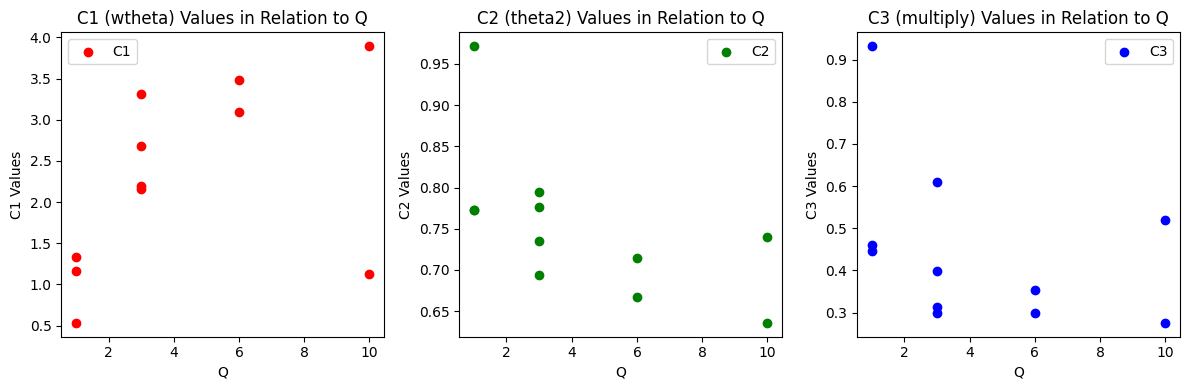

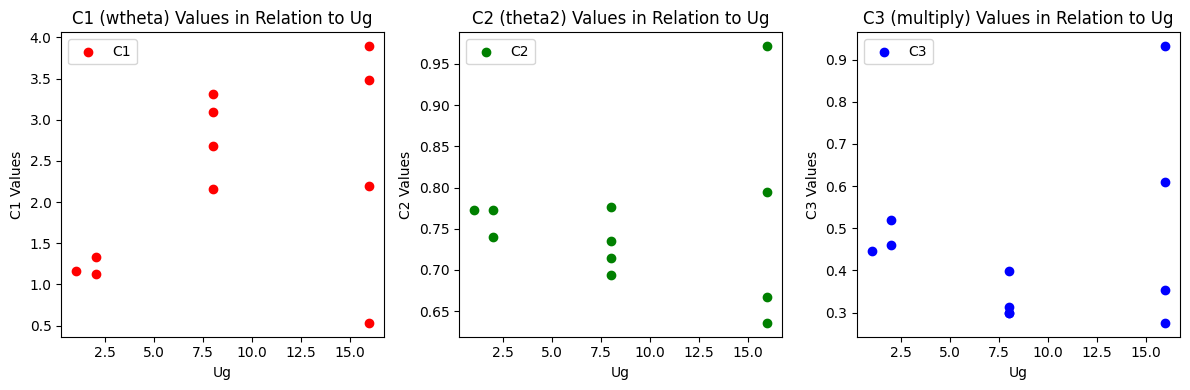

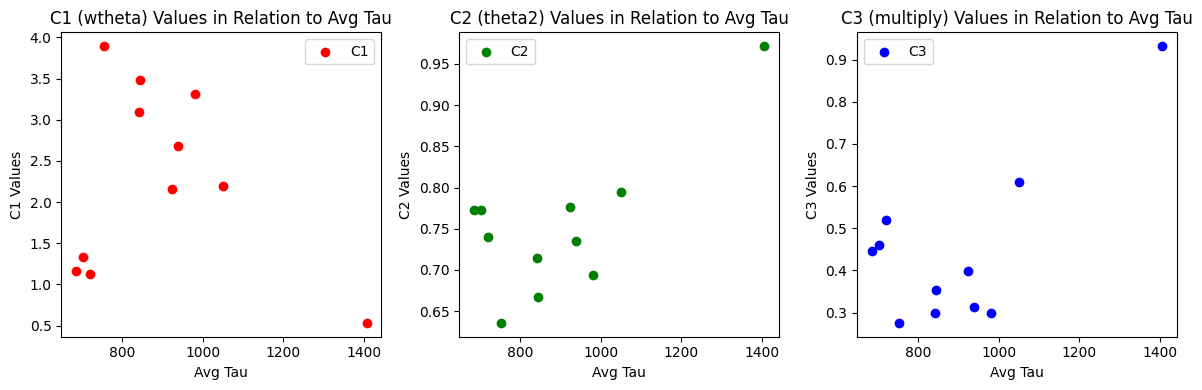

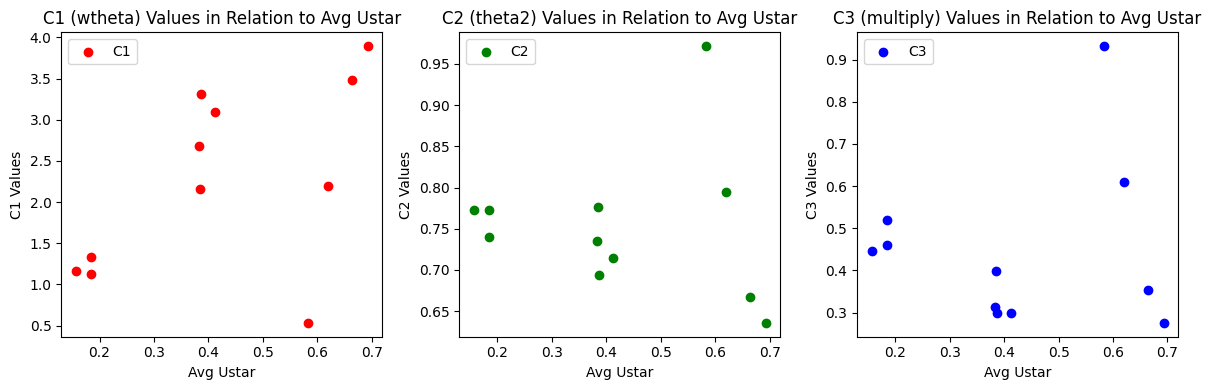

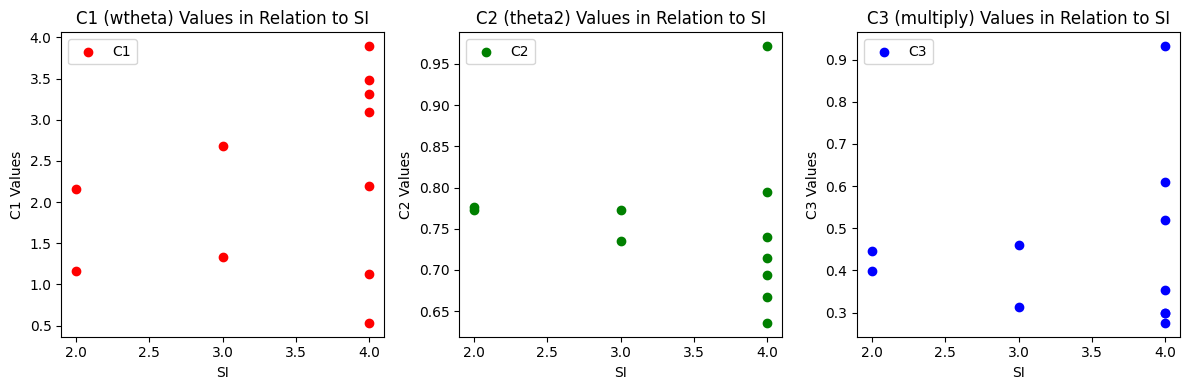

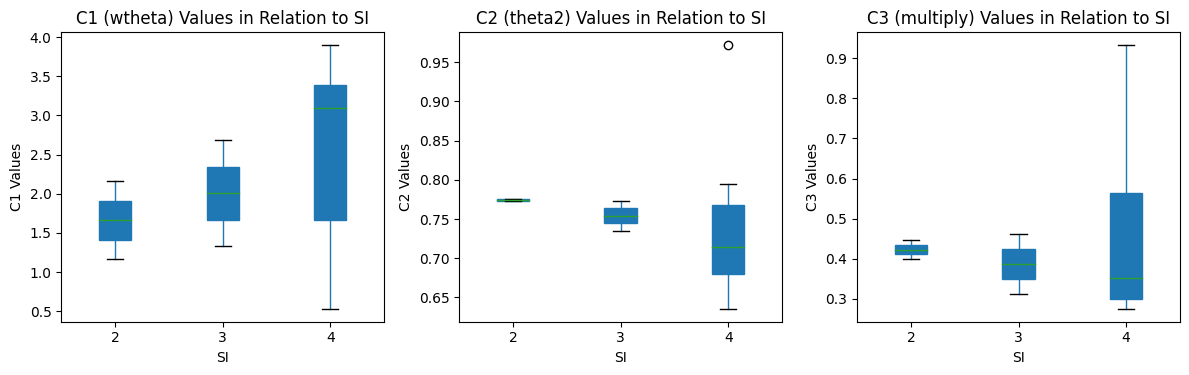

In [13]:
###### FOR Q ############################################################
plt.figure(figsize=(12, 4))

# Plot C1
plt.subplot(1, 3, 1)
plt.scatter(df_coefs['Q'], df_coefs['C1'], label='C1', marker='o', color = "red")
plt.xlabel('Q')
plt.ylabel('C1 Values')
plt.title('C1 (wtheta) Values in Relation to Q')
plt.legend()

# Plot C2
plt.subplot(1, 3, 2)
plt.scatter(df_coefs['Q'], df_coefs['C2'], label='C2', marker='o', color = "green")
plt.xlabel('Q')
plt.ylabel('C2 Values')
plt.title('C2 (theta2) Values in Relation to Q')
plt.legend()

# Plot C3
plt.subplot(1, 3, 3)
plt.scatter(df_coefs['Q'], df_coefs['C3'], label='C3', marker='o', color = "blue")
plt.xlabel('Q')
plt.ylabel('C3 Values')
plt.title('C3 (multiply) Values in Relation to Q')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


###### FOR UG ############################################################
plt.figure(figsize=(12, 4))

# Plot C1
plt.subplot(1, 3, 1)
plt.scatter(df_coefs['Ug'], df_coefs['C1'], label='C1', marker='o', color = "red")
plt.xlabel('Ug')
plt.ylabel('C1 Values')
plt.title('C1 (wtheta) Values in Relation to Ug')
plt.legend()

# Plot C2
plt.subplot(1, 3, 2)
plt.scatter(df_coefs['Ug'], df_coefs['C2'], label='C2', marker='o', color = "green")
plt.xlabel('Ug')
plt.ylabel('C2 Values')
plt.title('C2 (theta2) Values in Relation to Ug')
plt.legend()

# Plot C3
plt.subplot(1, 3, 3)
plt.scatter(df_coefs['Ug'], df_coefs['C3'], label='C3', marker='o', color = "blue")
plt.xlabel('Ug')
plt.ylabel('C3 Values')
plt.title('C3 (multiply) Values in Relation to Ug')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


###### FOR TAU ############################################################
plt.figure(figsize=(12, 4))

# Plot C1
plt.subplot(1, 3, 1)
plt.scatter(df_coefs['Avg Tau'], df_coefs['C1'], label='C1', marker='o', color = "red")
plt.xlabel('Avg Tau')
plt.ylabel('C1 Values')
plt.title('C1 (wtheta) Values in Relation to Avg Tau')
plt.legend()

# Plot C2
plt.subplot(1, 3, 2)
plt.scatter(df_coefs['Avg Tau'], df_coefs['C2'], label='C2', marker='o', color = "green")
plt.xlabel('Avg Tau')
plt.ylabel('C2 Values')
plt.title('C2 (theta2) Values in Relation to Avg Tau')
plt.legend()

# Plot C3
plt.subplot(1, 3, 3)
plt.scatter(df_coefs['Avg Tau'], df_coefs['C3'], label='C3', marker='o', color = "blue")
plt.xlabel('Avg Tau')
plt.ylabel('C3 Values')
plt.title('C3 (multiply) Values in Relation to Avg Tau')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


###### FOR USTAR ############################################################
plt.figure(figsize=(12, 4))

# Plot C1
plt.subplot(1, 3, 1)
plt.scatter(df_coefs['Avg Ustar'], df_coefs['C1'], label='C1', marker='o', color = "red")
plt.xlabel('Avg Ustar')
plt.ylabel('C1 Values')
plt.title('C1 (wtheta) Values in Relation to Avg Ustar')
plt.legend()

# Plot C2
plt.subplot(1, 3, 2)
plt.scatter(df_coefs['Avg Ustar'], df_coefs['C2'], label='C2', marker='o', color = "green")
plt.xlabel('Avg Ustar')
plt.ylabel('C2 Values')
plt.title('C2 (theta2) Values in Relation to Avg Ustar')
plt.legend()

# Plot C3
plt.subplot(1, 3, 3)
plt.scatter(df_coefs['Avg Ustar'], df_coefs['C3'], label='C3', marker='o', color = "blue")
plt.xlabel('Avg Ustar')
plt.ylabel('C3 Values')
plt.title('C3 (multiply) Values in Relation to Avg Ustar')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


###### FOR INVERSION STRENGTH ############################################################
plt.figure(figsize=(12, 4))

# Plot C1
plt.subplot(1, 3, 1)
plt.scatter(df_coefs['Inversion Strength'], df_coefs['C1'], label='C1', marker='o', color = "red")
plt.xlabel('SI')
plt.ylabel('C1 Values')
plt.title('C1 (wtheta) Values in Relation to SI')
plt.legend()

# Plot C2
plt.subplot(1, 3, 2)
plt.scatter(df_coefs['Inversion Strength'], df_coefs['C2'], label='C2', marker='o', color = "green")
plt.xlabel('SI')
plt.ylabel('C2 Values')
plt.title('C2 (theta2) Values in Relation to SI')
plt.legend()

# Plot C3
plt.subplot(1, 3, 3)
plt.scatter(df_coefs['Inversion Strength'], df_coefs['C3'], label='C3', marker='o', color = "blue")
plt.xlabel('SI')
plt.ylabel('C3 Values')
plt.title('C3 (multiply) Values in Relation to SI')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

plt.figure(figsize=(12, 4))

# Plot C1
plt.subplot(1, 3, 1)
df_coefs.boxplot(column='C1', by='Inversion Strength', grid=False, ax=plt.gca(), patch_artist=True)
plt.xlabel('SI')
plt.ylabel('C1 Values')
plt.title('C1 (wtheta) Values in Relation to SI')
plt.suptitle('')  # Suppress the automatic title

# Plot C2
plt.subplot(1, 3, 2)
df_coefs.boxplot(column='C2', by='Inversion Strength', grid=False, ax=plt.gca(), patch_artist=True)
plt.xlabel('SI')
plt.ylabel('C2 Values')
plt.title('C2 (theta2) Values in Relation to SI')
plt.suptitle('')  # Suppress the automatic title

# Plot C3
plt.subplot(1, 3, 3)
df_coefs.boxplot(column='C3', by='Inversion Strength', grid=False, ax=plt.gca(), patch_artist=True)
plt.xlabel('SI')
plt.ylabel('C3 Values')
plt.title('C3 (multiply) Values in Relation to SI')
plt.suptitle('')  # Suppress the automatic title

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

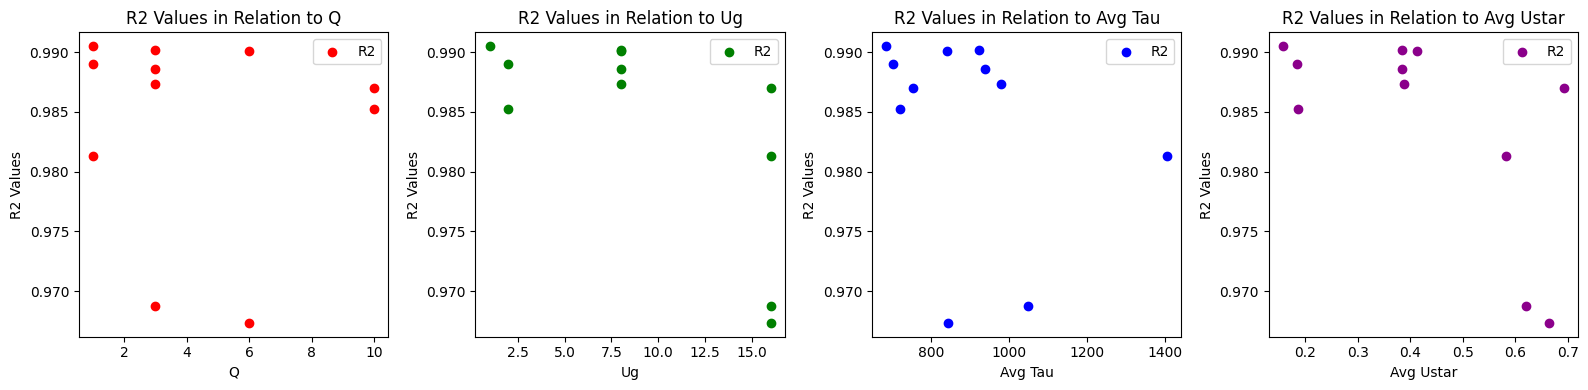

In [14]:
###### Is there any relationship between fit and the forcings??? ################
plt.figure(figsize=(16, 4))

# Plot R2 vs. Q
plt.subplot(1, 4, 1)
plt.scatter(df_coefs['Q'], df_coefs['R2'], label='R2', marker='o', color='red')
plt.xlabel('Q')
plt.ylabel('R2 Values')
plt.title('R2 Values in Relation to Q')
plt.legend()

# Plot R2 vs. Ug
plt.subplot(1, 4, 2)
plt.scatter(df_coefs['Ug'], df_coefs['R2'], label='R2', marker='o', color='green')
plt.xlabel('Ug')
plt.ylabel('R2 Values')
plt.title('R2 Values in Relation to Ug')
plt.legend()

# Plot R2 vs. Avg Tau
plt.subplot(1, 4, 3)
plt.scatter(df_coefs['Avg Tau'], df_coefs['R2'], label='R2', marker='o', color='blue')
plt.xlabel('Avg Tau')
plt.ylabel('R2 Values')
plt.title('R2 Values in Relation to Avg Tau')
plt.legend()

# Plot R2 vs. Avg Ustar
plt.subplot(1, 4, 4)
plt.scatter(df_coefs['Avg Ustar'], df_coefs['R2'], label='R2', marker='o', color='darkmagenta')
plt.xlabel('Avg Ustar')
plt.ylabel('R2 Values')
plt.title('R2 Values in Relation to Avg Ustar')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


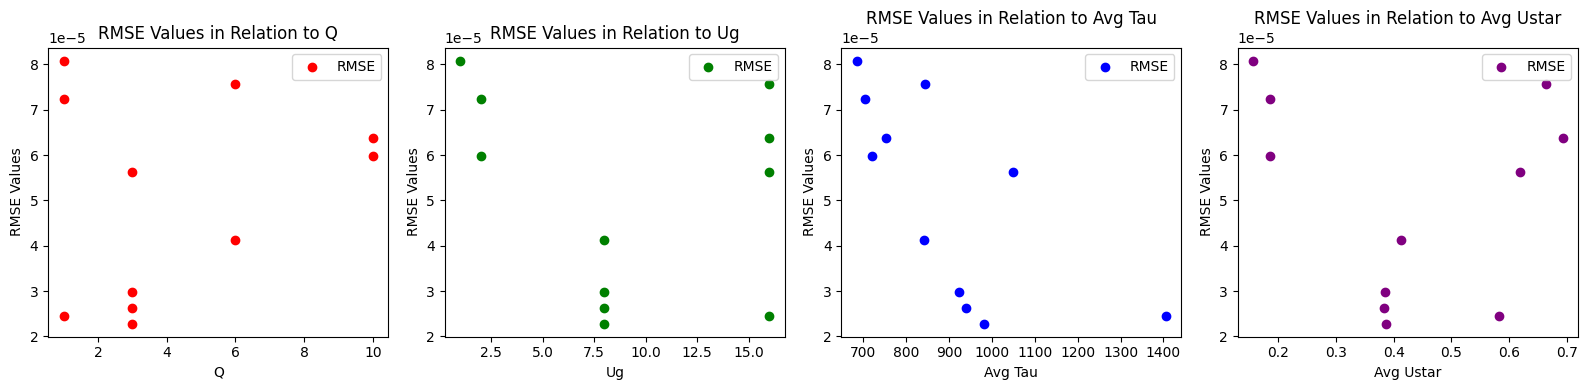

In [15]:
###### Is there any relationship between fit and the forcings??? ################
plt.figure(figsize=(16, 4))

# Plot RMSE vs. Q
plt.subplot(1, 4, 1)
plt.scatter(df_coefs['Q'], df_coefs['RMSE'], label='RMSE', marker='o', color='red')
plt.xlabel('Q')
plt.ylabel('RMSE Values')
plt.title('RMSE Values in Relation to Q')
plt.legend()

# Plot RMSE vs. Ug
plt.subplot(1, 4, 2)
plt.scatter(df_coefs['Ug'], df_coefs['RMSE'], label='RMSE', marker='o', color='green')
plt.xlabel('Ug')
plt.ylabel('RMSE Values')
plt.title('RMSE Values in Relation to Ug')
plt.legend()

# Plot RMSE vs. Avg Tau
plt.subplot(1, 4, 3)
plt.scatter(df_coefs['Avg Tau'], df_coefs['RMSE'], label='RMSE', marker='o', color='blue')
plt.xlabel('Avg Tau')
plt.ylabel('RMSE Values')
plt.title('RMSE Values in Relation to Avg Tau')
plt.legend()

# Plot RMSE vs. Avg Ustar
plt.subplot(1, 4, 4)
plt.scatter(df_coefs['Avg Ustar'], df_coefs['RMSE'], label='RMSE', marker='o', color='purple')
plt.xlabel('Avg Ustar')
plt.ylabel('RMSE Values')
plt.title('RMSE Values in Relation to Avg Ustar')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


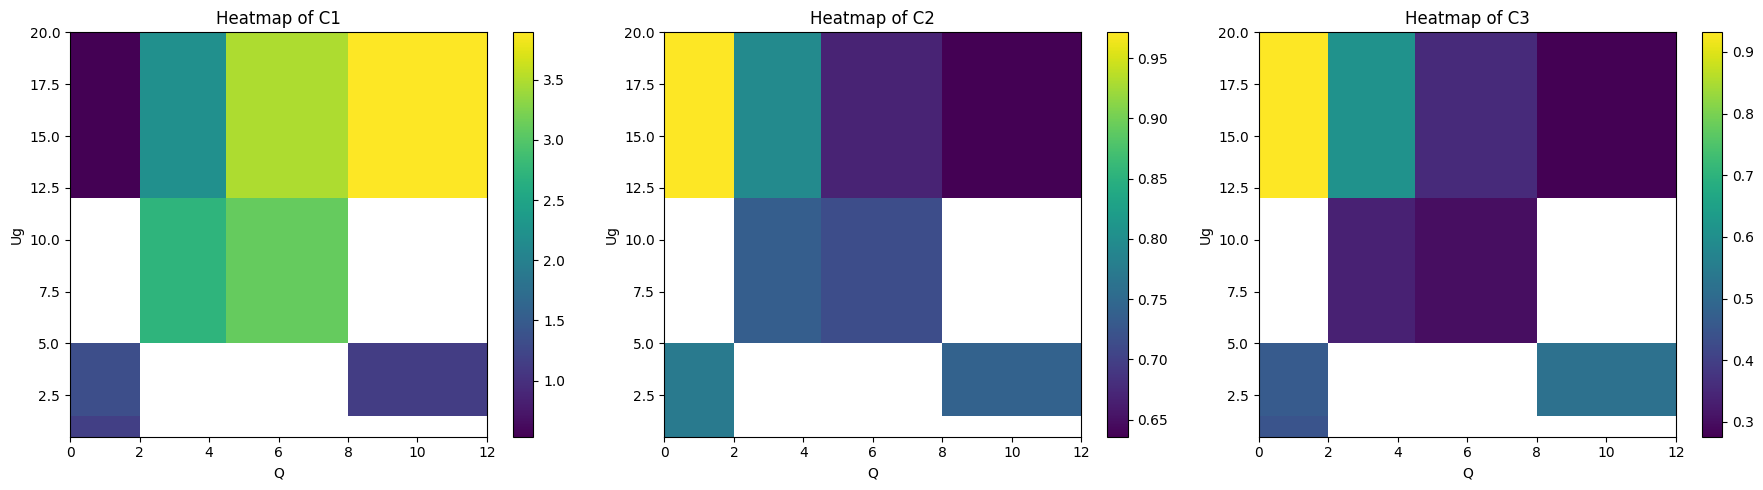

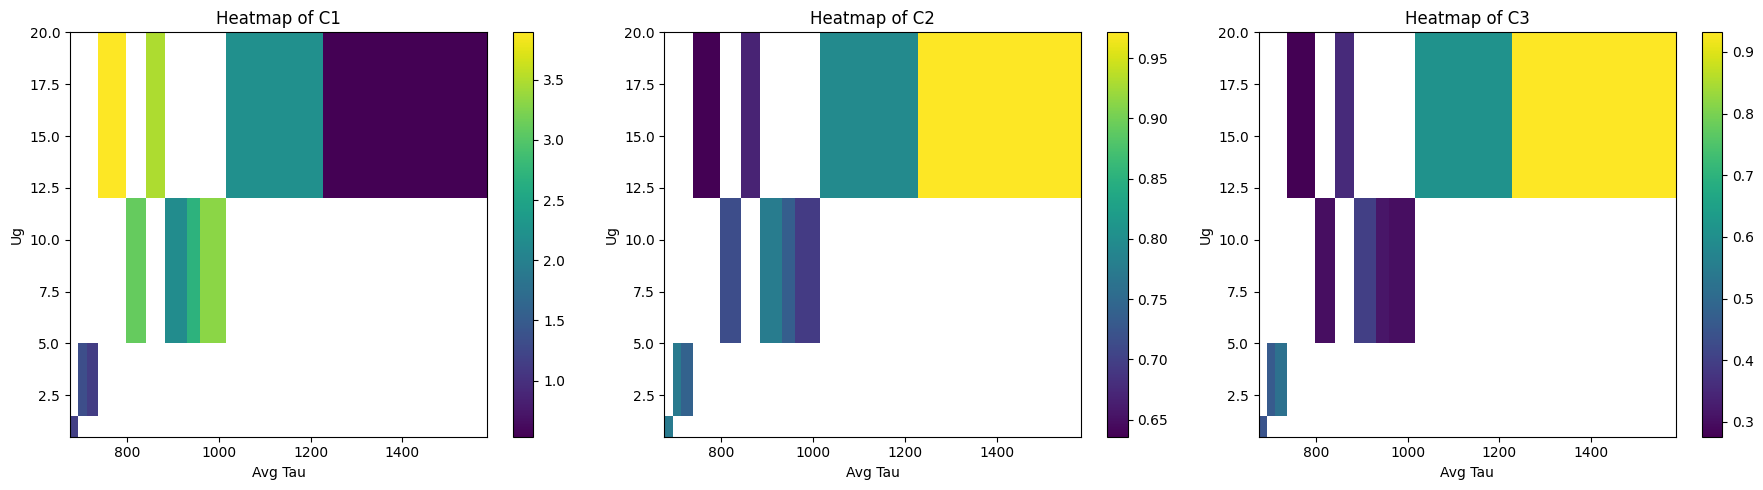

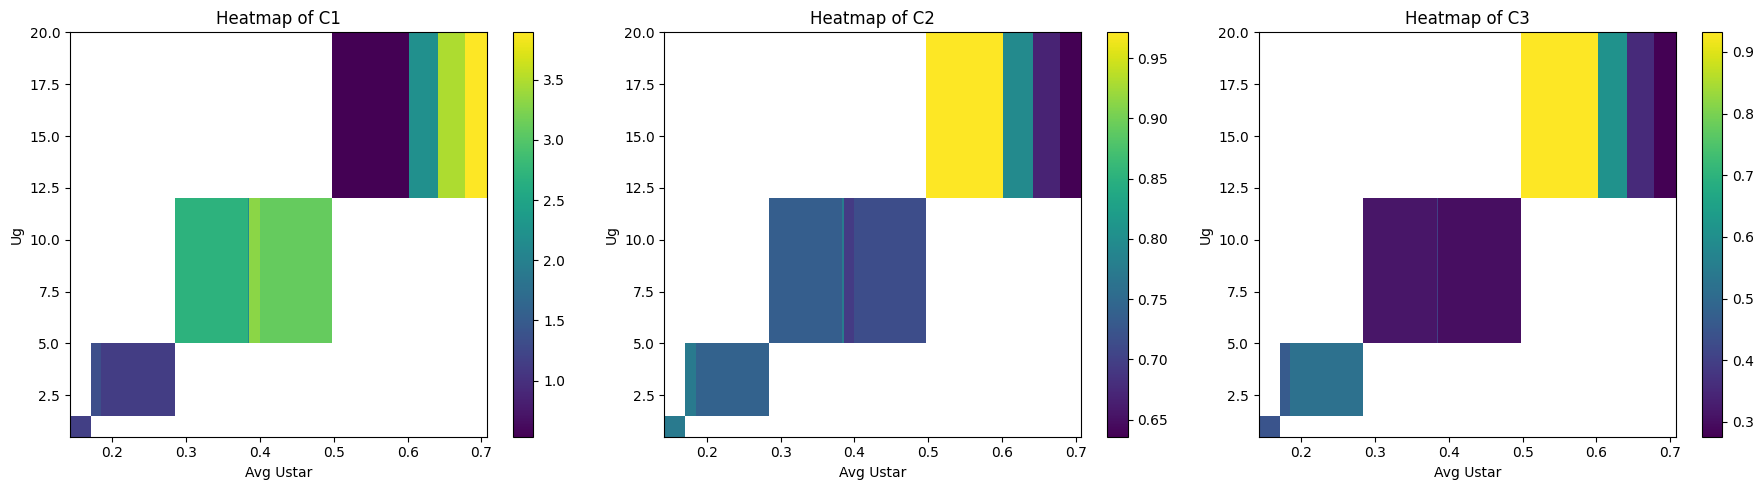

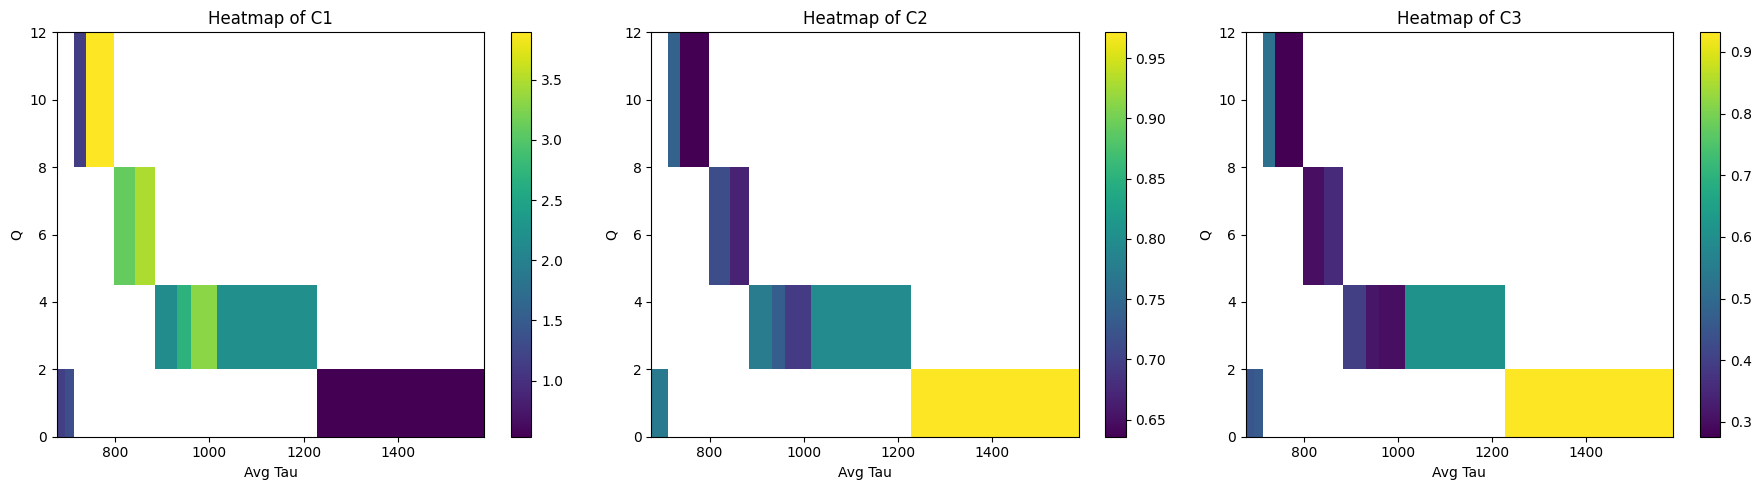

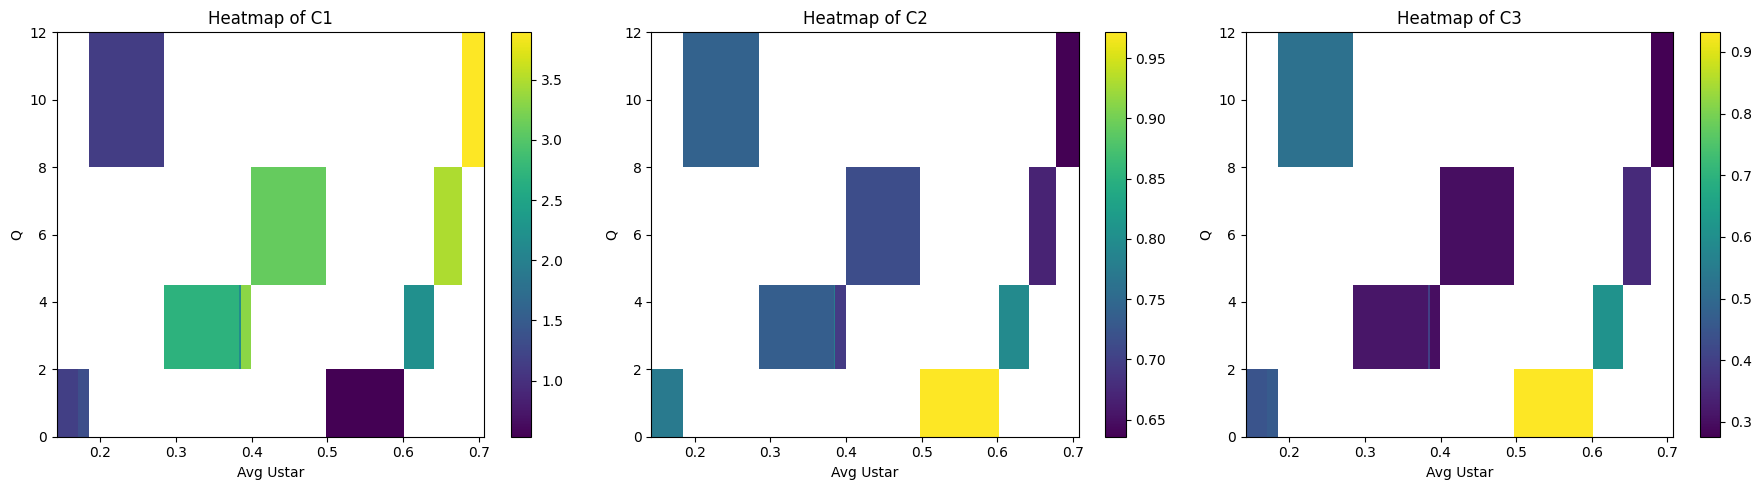

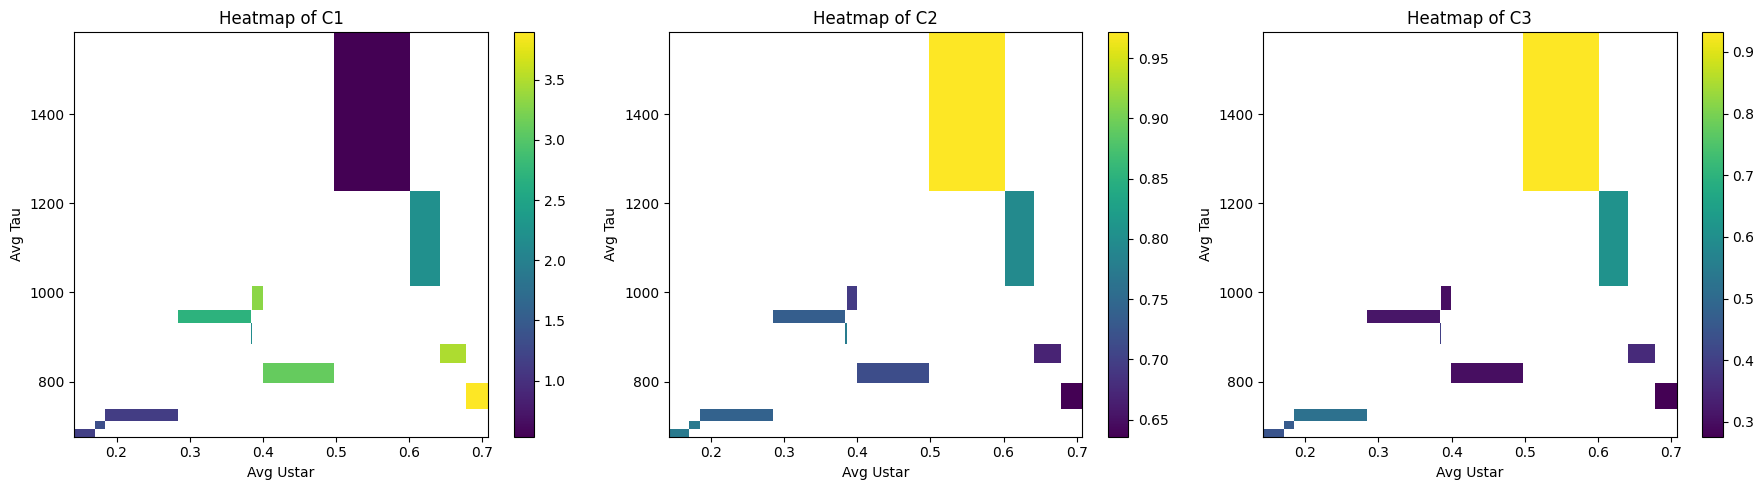

In [16]:
############## UG AND Q ########################################################
# Pivot tables to create 2D arrays
C1_grid = df_coefs.pivot_table(index='Ug', columns='Q', values='C1')
C2_grid = df_coefs.pivot_table(index='Ug', columns='Q', values='C2')
C3_grid = df_coefs.pivot_table(index='Ug', columns='Q', values='C3')

# Create a meshgrid for Q and Ug
Q_values = C1_grid.columns
Ug_values = C1_grid.index
Q_grid, Ug_grid = np.meshgrid(Q_values, Ug_values)

# Function to create heatmap
def create_heatmap(ax, Q, Ug, C, title):
    heatmap = ax.pcolormesh(Q, Ug, C, shading='auto', cmap='viridis')
    ax.set_xlabel('Q')
    ax.set_ylabel('Ug')
    ax.set_title(title)
    plt.colorbar(heatmap, ax=ax)

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

create_heatmap(axes[0], Q_grid, Ug_grid, C1_grid.values, 'Heatmap of C1')
create_heatmap(axes[1], Q_grid, Ug_grid, C2_grid.values, 'Heatmap of C2')
create_heatmap(axes[2], Q_grid, Ug_grid, C3_grid.values, 'Heatmap of C3')

plt.tight_layout()
plt.show()



############## UG AND AVG TAU ########################################################
# Pivot tables to create 2D arrays
C1_grid = df_coefs.pivot_table(index='Ug', columns='Avg Tau', values='C1')
C2_grid = df_coefs.pivot_table(index='Ug', columns='Avg Tau', values='C2')
C3_grid = df_coefs.pivot_table(index='Ug', columns='Avg Tau', values='C3')

# Create a meshgrid for Avg Tau and Ug
Tau_values = C1_grid.columns
Ug_values = C1_grid.index
Tau_grid, Ug_grid = np.meshgrid(Tau_values, Ug_values)

# Function to create heatmap
def create_heatmap(ax, Tau, Ug, C, title):
    heatmap = ax.pcolormesh(Tau, Ug, C, shading='auto', cmap='viridis')
    ax.set_xlabel('Avg Tau')
    ax.set_ylabel('Ug')
    ax.set_title(title)
    plt.colorbar(heatmap, ax=ax)

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

create_heatmap(axes[0], Tau_grid, Ug_grid, C1_grid.values, 'Heatmap of C1')
create_heatmap(axes[1], Tau_grid, Ug_grid, C2_grid.values, 'Heatmap of C2')
create_heatmap(axes[2], Tau_grid, Ug_grid, C3_grid.values, 'Heatmap of C3')

plt.tight_layout()
plt.show()



############## UG AND AVG USTAR ########################################################

# Pivot tables to create 2D arrays
C1_grid = df_coefs.pivot_table(index='Ug', columns='Avg Ustar', values='C1')
C2_grid = df_coefs.pivot_table(index='Ug', columns='Avg Ustar', values='C2')
C3_grid = df_coefs.pivot_table(index='Ug', columns='Avg Ustar', values='C3')

# Create a meshgrid for Avg Ustar and Ug
Ustar_values = C1_grid.columns
Ug_values = C1_grid.index
Ustar_grid, Ug_grid = np.meshgrid(Ustar_values, Ug_values)

# Function to create heatmap
def create_heatmap(ax, Ustar, Ug, C, title):
    heatmap = ax.pcolormesh(Ustar, Ug, C, shading='auto', cmap='viridis')
    ax.set_xlabel('Avg Ustar')
    ax.set_ylabel('Ug')
    ax.set_title(title)
    plt.colorbar(heatmap, ax=ax)

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

create_heatmap(axes[0], Ustar_grid, Ug_grid, C1_grid.values, 'Heatmap of C1')
create_heatmap(axes[1], Ustar_grid, Ug_grid, C2_grid.values, 'Heatmap of C2')
create_heatmap(axes[2], Ustar_grid, Ug_grid, C3_grid.values, 'Heatmap of C3')

plt.tight_layout()
plt.show()



############## Q AND AVG TAU ########################################################
# Pivot tables to create 2D arrays
C1_grid = df_coefs.pivot_table(index='Q', columns='Avg Tau', values='C1')
C2_grid = df_coefs.pivot_table(index='Q', columns='Avg Tau', values='C2')
C3_grid = df_coefs.pivot_table(index='Q', columns='Avg Tau', values='C3')

# Create a meshgrid for Avg Tau and Q
Tau_values = C1_grid.columns
Q_values = C1_grid.index
Tau_grid, Q_grid = np.meshgrid(Tau_values, Q_values)

# Function to create heatmap
def create_heatmap(ax, Tau, Q, C, title):
    heatmap = ax.pcolormesh(Tau, Q, C, shading='auto', cmap='viridis')
    ax.set_xlabel('Avg Tau')
    ax.set_ylabel('Q')
    ax.set_title(title)
    plt.colorbar(heatmap, ax=ax)

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

create_heatmap(axes[0], Tau_grid, Q_grid, C1_grid.values, 'Heatmap of C1')
create_heatmap(axes[1], Tau_grid, Q_grid, C2_grid.values, 'Heatmap of C2')
create_heatmap(axes[2], Tau_grid, Q_grid, C3_grid.values, 'Heatmap of C3')

plt.tight_layout()
plt.show()



############## Q AND AVG USTAR ########################################################
# Pivot tables to create 2D arrays
C1_grid = df_coefs.pivot_table(index='Q', columns='Avg Ustar', values='C1')
C2_grid = df_coefs.pivot_table(index='Q', columns='Avg Ustar', values='C2')
C3_grid = df_coefs.pivot_table(index='Q', columns='Avg Ustar', values='C3')

# Create a meshgrid for Avg Ustar and Q
Ustar_values = C1_grid.columns
Q_values = C1_grid.index
Ustar_grid, Q_grid = np.meshgrid(Ustar_values, Q_values)

# Function to create heatmap
def create_heatmap(ax, Ustar, Q, C, title):
    heatmap = ax.pcolormesh(Ustar, Q, C, shading='auto', cmap='viridis')
    ax.set_xlabel('Avg Ustar')
    ax.set_ylabel('Q')
    ax.set_title(title)
    plt.colorbar(heatmap, ax=ax)

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

create_heatmap(axes[0], Ustar_grid, Q_grid, C1_grid.values, 'Heatmap of C1')
create_heatmap(axes[1], Ustar_grid, Q_grid, C2_grid.values, 'Heatmap of C2')
create_heatmap(axes[2], Ustar_grid, Q_grid, C3_grid.values, 'Heatmap of C3')

plt.tight_layout()
plt.show()


############## AVG TAU AND AVG USTAR ########################################################
# Pivot tables to create 2D arrays
C1_grid = df_coefs.pivot_table(index='Avg Tau', columns='Avg Ustar', values='C1')
C2_grid = df_coefs.pivot_table(index='Avg Tau', columns='Avg Ustar', values='C2')
C3_grid = df_coefs.pivot_table(index='Avg Tau', columns='Avg Ustar', values='C3')

# Create a meshgrid for Avg Tau and Avg Ustar
Tau_values = C1_grid.columns
Ustar_values = C1_grid.index
Tau_grid, Ustar_grid = np.meshgrid(Tau_values, Ustar_values)

# Function to create heatmap
def create_heatmap(ax, Tau, Ustar, C, title):
    heatmap = ax.pcolormesh(Tau, Ustar, C, shading='auto', cmap='viridis')
    ax.set_xlabel('Avg Ustar')
    ax.set_ylabel('Avg Tau')
    ax.set_title(title)
    plt.colorbar(heatmap, ax=ax)

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

create_heatmap(axes[0], Tau_grid, Ustar_grid, C1_grid.values, 'Heatmap of C1')
create_heatmap(axes[1], Tau_grid, Ustar_grid, C2_grid.values, 'Heatmap of C2')
create_heatmap(axes[2], Tau_grid, Ustar_grid, C3_grid.values, 'Heatmap of C3')

plt.tight_layout()
plt.show()


In [17]:
df_coefs

,File,Avg Ustar,Avg Tau,Ug,Q,RMSE,R2,C1,C2,C3,Inversion Strength
0,Ug16Q001_IV.nc,0.583217,1405.862176,16,1,0.000024,0.981304,0.534015,0.971441,0.931903,4
1,Ug16Q003_IV.nc,0.619608,1049.518786,16,3,0.000056,0.968710,2.200838,0.794898,0.608740,4
2,Ug16Q006_IV.nc,0.663322,843.801678,16,6,0.000076,0.967333,3.480432,0.667441,0.352913,4
3,Ug16Q010_IV.nc,0.692744,753.947342,16,10,0.000064,0.986968,3.892732,0.635783,0.275732,4
4,Ug1Q01_II.nc,0.156549,685.283322,1,1,0.000081,0.990494,1.160933,0.772905,0.447008,2
5,Ug2Q010_IV.nc,0.185135,721.373486,2,10,0.000060,0.985244,1.130810,0.739922,0.519088,4
6,Ug2Q01_III.nc,0.184706,703.534752,2,1,0.000072,0.988998,1.330275,0.773037,0.461213,3
7,Ug8Q003_II.nc,0.384079,923.887276,8,3,0.000030,0.990180,2.158704,0.775836,0.398563,2
8,Ug8Q003_III.nc,0.383418,939.150159,8,3,0.000026,0.988617,2.686453,0.735105,0.312753,3
9,Ug8Q003_IV.nc,0.387227,980.796441,8,3,0.000023,0.987343,3.306518,0.693531,0.299167,4


In [18]:
df_X_l = df_coefs[['Avg Ustar', 'Avg Tau', 'Ug', 'Q']]
df_X_l = df_X_l.rename(columns={'Avg Ustar': 'Ustar', 'Avg Tau': 'Tau', 'Q': 'Q_ic'})
df_C1 = df_coefs['C1']
df_C2 = df_coefs['C2']
df_C3 = df_coefs['C3']

In [19]:
df_X_l

,Ustar,Tau,Ug,Q_ic
0,0.583217,1405.862176,16,1
1,0.619608,1049.518786,16,3
2,0.663322,843.801678,16,6
3,0.692744,753.947342,16,10
4,0.156549,685.283322,1,1
5,0.185135,721.373486,2,10
6,0.184706,703.534752,2,1
7,0.384079,923.887276,8,3
8,0.383418,939.150159,8,3
9,0.387227,980.796441,8,3


In [20]:
df_c1_eqs = discover_coef_eqs(df_X_l, df_C1)

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.360e+05
Head worker occupation: 17.0%
Progress: 653 / 7500 total iterations (8.707%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.133e+00  1.594e+01  y = 2.2705
3           9.556e-01  8.526e-02  y = Ustar + 1.8476
5           5.444e-01  2.813e-01  y = 3.2336 + (-2.1769 / Q_ic)
7           1.965e-01  5.096e-01  y = (-2.6865 - Ug) + (33.432 * Ustar)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.270e+05
Head worker occupation: 16.7%
Progress: 1347 / 7500 total iterations (17.960%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.133e+00  1.594e+01  y = 2.2705
3          

In [21]:
df_c1_eqs

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,1.133256,0.000000,2.2704654,2.27046540000000,PySRFunction(X=>2.27046540000000)
1,3,0.955595,0.085258,Ustar + 1.8475629,Ustar + 1.8475629,PySRFunction(X=>Ustar + 1.8475629)
2,5,0.540391,0.285020,Ustar / (Tau / 4665.366),4665.366*Ustar/Tau,PySRFunction(X=>4665.366*Ustar/Tau)
3,7,0.196459,0.505920,(-2.68645 - Ug) + (33.432346 * Ustar),-Ug + 33.432346*Ustar - 2.68645,PySRFunction(X=>-Ug + 33.432346*Ustar - 2.68645)


In [22]:
df_c2_eqs = discover_coef_eqs(df_X_l, df_C2)

[ Info: Started!



Expressions evaluated per second: 2.300e+05
Head worker occupation: 21.0%
Progress: 656 / 7500 total iterations (8.747%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           7.035e-03  1.594e+01  y = 0.75219
5           3.466e-03  1.769e-01  y = 0.48203 - (-0.00030173 * Tau)
7           3.464e-03  3.339e-04  y = (0.48275 + Tau) - (Tau * 0.9997)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.280e+05
Head worker occupation: 20.5%
Progress: 1322 / 7500 total iterations (17.627%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           7.035e-03  1.594e+01  y = 0.75219
5           3.466e-03  1.769e-01  y = 0.48203 - (-0.0003017

In [23]:
df_c2_eqs

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.007035,0.000000,0.7521899,0.752189900000000,PySRFunction(X=>0.752189900000000)
1,5,0.003466,0.176933,0.48204175 - (-0.00030172348 * Tau),0.00030172348*Tau + 0.48204175,PySRFunction(X=>0.00030172348*Tau + 0.48204175)
2,7,0.001701,0.355939,(0.05227969 / Ustar) + (Tau * 0.0006568741),0.0006568741*Tau + 0.05227969/Ustar,PySRFunction(X=>0.0006568741*Tau + 0.05227969/...


In [24]:
df_c3_eqs = discover_coef_eqs(df_X_l, df_C3)

[ Info: Started!



Expressions evaluated per second: 2.310e+05
Head worker occupation: 19.4%
Progress: 661 / 7500 total iterations (8.813%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.352e-02  1.594e+01  y = 0.44607
3           1.837e-02  3.008e-01  y = 0.00050466 * Tau
5           8.970e-03  3.584e-01  y = (Ustar / Q_ic) + 0.28399
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.420e+05
Head worker occupation: 19.5%
Progress: 1343 / 7500 total iterations (17.907%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.352e-02  1.594e+01  y = 0.44607
3           1.837e-02  3.008e-01  y = 0.00050466 * Tau
5           8.970e-03  3.

In [25]:
df_c3_eqs

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.033524,0.000000,0.44607463,0.446074630000000,PySRFunction(X=>0.446074630000000)
1,3,0.018369,0.300789,0.0005046605 * Tau,0.0005046605*Tau,PySRFunction(X=>0.0005046605*Tau)
2,5,0.008970,0.358396,(Ustar / Q_ic) + 0.28399462,0.28399462 + Ustar/Q_ic,PySRFunction(X=>0.28399462 + Ustar/Q_ic)


- (maybe create jittered/noisy variables for better fit, look up how much paper needs)

other things to think abt: 
- ustar in front of third term (punished coefficient complexity) (think abt)
- parametrization for dwwtheta/dz

final presi will be: 
1. the problem (background on turbulence, atmospheric boundary layer, etc)
2. the methodology (PYSR, how does it work, genetic algorithms, etc)
3. Re-disovery of the original equation.
4. Current work on improving the parametrization.

Sara will decide how she wants us to present: Hopefully either all three, or Laura and Greta together and then me separate. 